<a href="https://colab.research.google.com/github/rg-smith/groundwater_hydrology/blob/main/assignment1/change_in_storage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 1: getting different components of the water budget

This python workbook can be 'clicked through'. Just upload your watershed files into the main files tab, then click run on each code block.

In [ ]:
pip install geopandas geemap

In [ ]:
pip install pycrs

In [8]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from tqdm import tqdm
import zipfile
import os
import pandas as pd
from glob import glob
import geemap
import pycrs

if not ee.data._credentials:
    ee.Authenticate()
    ee.Initialize()

In [3]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def gee_zonal_mean_img_coll(imageCollection,geometry):
    reduce_iC = create_reduce_region_function(geometry = geometry)
    stat_fc = ee.FeatureCollection(imageCollection.map(reduce_iC)).filter(ee.Filter.notNull(imageCollection.first().bandNames()))
    fc_dict = fc_to_dict(stat_fc).getInfo()

    df = pd.DataFrame(fc_dict)
    df['date'] = pd.to_datetime(df['millis'],unit='ms')
    return(df)

def gee_zonal_mean(date1,date2,geometry,collection_name,band_name):
     imcol = ee.ImageCollection(collection_name).select(band_name).filterDate(date1,date2)
     df = gee_zonal_mean_img_coll(imcol,geometry)
     return(df)


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def ee_imgcoll_to_df_point(imagecollection, lat,lon):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    poi = ee.Geometry.Point(lon, lat)
    arr = imagecollection.getRegion(poi,1000).getInfo()

    list_of_bands = imagecollection.first().bandNames().getInfo()

    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

# to get the link to download an earth engine image
def getLink(image,fname,aoi):
  link = image.getDownloadURL({
    'scale': 1000,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi,
    'name': fname})
  # print(link)
  return(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

def get_imgcollection(date1,date2,geometry,collection_name,band_name,function='mean'):
  collection = ee.ImageCollection(collection_name)
  if function=='mean':
      img = collection.filterDate(date1,date2).select(band_name).mean().clip(geometry)
  if function=='sum':
      img = collection.filterDate(date1,date2).select(band_name).sum().clip(geometry)
  range = img.reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
  vals = range.getInfo()
  min=list(vals.items())[0][1]
  max=list(vals.items())[1][1]
  visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(img,visParams)

def download_img(img,geom,fname):
    linkname = getLink(img,fname,geom)
    response = requests.get(linkname, stream=True)
    zipped = fname+'.zip'
    with open(zipped, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('')
    os.remove(zipped)


def aggregate_by_water_year(df,date_col,agg_column,agg_fun='sum'):
    df['water_year'] = df[date_col].dt.year.where(df[date_col].dt.month < 10, df[date_col].dt.year + 1)
    df_agg = df.groupby('water_year').agg({agg_column:[agg_fun]})
    return(df_agg)

First, upload your watershed shapefile to the files directory. Be sure to include ALL FILES WITH THE SAME STEM (.shp, .dbf, .prj, .shx, etc). Put it in the main directory.

In [4]:
start='2015-10-01'
end='2016-09-30'
path_to_watershed='globalwatershed.shp'

In [9]:
# upload watershed to GEE----------------------------
watershed_gee = geemap.shp_to_ee(path_to_watershed)

area of watershed is 2917 square km


<Axes: >

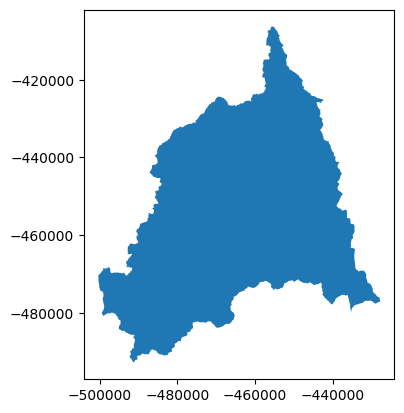

In [13]:
# get watershed area (sq km)
wshed = gpd.read_file(path_to_watershed)
wshed_proj = wshed.to_crs(epsg = '2163')
area = wshed_proj.geometry.area/1e6
print('area of watershed is '+str(int(area))+' square km')

wshed_proj.plot()

In [11]:
# get data frames that are spatially reduced
df_precip = gee_zonal_mean(start,end,watershed_gee.geometry(),'OREGONSTATE/PRISM/AN81m','ppt')
df_precip = df_precip[['ppt','date']]
df_precip.to_csv('precipitation.csv')

print('area averaged annual precip in watershed is '+str(int(np.sum(df_precip['ppt'])))+ ' mm')

df_ET = gee_zonal_mean(start,end,watershed_gee.geometry(),'MODIS/006/MOD16A2','ET')
df_ET = df_ET[['ET','date']]
df_ET['ET'] = df_ET['ET']/10
df_ET.to_csv('ET.csv')

print('area averaged annual ET in watershed is '+str(int(np.sum(df_ET['ET'])))+ ' mm')

df_sm = gee_zonal_mean(start,end,watershed_gee.geometry(),'NASA_USDA/HSL/SMAP10KM_soil_moisture','susm')

df_sm = df_sm[['susm','date']]
df_sm.to_csv('sm.csv')
sm = np.array(df_sm['susm'])

print('area averaged change in subsurface soil water storage is '+str(int(sm[-1]-sm[0]))+ ' mm')


area averaged annual precip in watershed is 543 mm
area averaged annual ET in watershed is 374 mm
area averaged change in subsurface soil water storage is -5 mm
